<a href="https://colab.research.google.com/github/GraceMcPadden2/RL-Portfolio-Allocation/blob/main/stock_rl_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U "gymnasium>=0.29" "stable-baselines3>=2.3.0" "numpy>=2.0" pandas pandas-datareader matplotlib



In [10]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import math
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from scipy.special import softmax
import matplotlib.pyplot as plt

# --- Config ---
TICKERS = ["GLD.US", "SPY.US","IEF.US"]     # Gold, US Equity, US Bonds
LOOKBACK = 60                       # days of history in obs
TRAIN_START, TRAIN_END = "2020-01-01", "2022-12-31"
TEST_START, TEST_END   = "2023-01-01", "2025-10-01"

RISK_FREE = 0.00                    # daily rf ≈ 0 for simplicity
ETA = 1/252                         # EMA scale for Differential Sharpe
SEED = 42
np.random.seed(SEED)


In [11]:
def get_prices(tickers, start, end):
    """Download Close prices from Stooq (sorted ascending)."""
    if isinstance(tickers, str):
        tickers = [tickers]

    data = pd.concat(
        [
            web.DataReader(t, "stooq")[["Close"]]
            .rename(columns={"Close": t})
            .sort_index()
            .loc[pd.to_datetime(start): pd.to_datetime(end)]
            for t in tickers
        ],
        axis=1
    )
    return data.dropna()


prices_train = get_prices(TICKERS, TRAIN_START, TRAIN_END)
prices_test  = get_prices(TICKERS, TEST_START, TEST_END)

# Daily log returns
logret_train = np.log(prices_train / prices_train.shift(1)).dropna()
logret_test  = np.log(prices_test / prices_test.shift(1)).dropna()

display(prices_train.tail(), logret_train.tail())

,GLD.US,SPY.US,IEF.US
Date,,,
2022-12-23,167.26,371.284,96.75
2022-12-27,168.67,369.821,95.94
2022-12-28,167.91,365.225,95.71
2022-12-29,168.85,371.798,96.18
2022-12-30,169.64,370.819,95.78


,GLD.US,SPY.US,IEF.US
Date,,,
2022-12-23,0.002994,0.005737,-0.004537
2022-12-27,0.008395,-0.003948,-0.008407
2022-12-28,-0.004516,-0.012506,-0.002400
2022-12-29,0.005583,0.017837,0.004899
2022-12-30,0.004668,-0.002637,-0.004168


In [14]:
class PortfolioEnv(gym.Env):
    """
    State: last LOOKBACK days of log-returns for each asset, flattened (N*LOOKBACK),
           plus previous weights (N)      -> shape = N*LOOKBACK + N
    Action: unconstrained R^N -> softmax -> long-only weights summing to 1
    Reward: Differential Sharpe (Moody et al.) using EMA updates (ETA)
    Dynamics: daily rebalancing, no tx costs (simple & consistent with the paper's base case)
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, log_returns: pd.DataFrame, lookback=60, eta=1/252, rf=0.0):
        super().__init__()
        self.returns = log_returns.values.astype(np.float32)  # shape [T, N]
        self.dates = log_returns.index
        self.assets = list(log_returns.columns)
        self.N = self.returns.shape[1]
        self.lookback = lookback
        self.eta = eta
        self.rf = rf

        # obs: N*lookback past logrets + previous weights N
        obs_len = self.N * self.lookback + self.N
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_len,), dtype=np.float32)

        # actions: unconstrained R^N (we softmax inside)
        self.action_space = spaces.Box(low=-10.0, high=10.0, shape=(self.N,), dtype=np.float32)

        self._reset_buffers()

    def _reset_buffers(self):
      self.t = self.lookback  # current index (first usable day)

      # --- Custom starting weights ---
      init_weights = {
          "SPY.US": 0.6,
          "IEF.US": 0.3,
          "GLD.US": 0.1
      }

      # Map weights in same order as self.assets, defaulting to 0.0 if not found
      self.w_prev = np.array([init_weights.get(a, 0.0) for a in self.assets], dtype=np.float32)

      # --- Safety check: handle missing or zero-sum weights ---
      total = np.sum(self.w_prev)
      if total <= 1e-8:
         # If sum is zero (e.g., asset names didn’t match), default to equal weights
         print(" Warning: custom weights didn’t match asset list — using equal weights instead.")
         self.w_prev = np.ones(self.N, dtype=np.float32) / self.N
      else:
         self.w_prev = self.w_prev / total  # normalize so weights sum to 1

      # Differential Sharpe tracking
      self.A = 0.0  # EMA of returns
      self.B = 0.0  # EMA of squared returns

      # Portfolio value starts at $1
      self.portfolio_value = 1.0

    def _obs(self):
        hist = self.returns[self.t - self.lookback:self.t, :].T.reshape(-1)  # (N*lookback,)
        return np.concatenate([hist, self.w_prev], axis=0).astype(np.float32)

    def step(self, action):
        # map action -> weights
        w = softmax(action, axis = -1)

        # realize asset returns at t (log-returns); convert to simple gross return:
        r_log = self.returns[self.t, :]            # log returns
        gross = np.exp(r_log)                      # R_t + 1
        # portfolio simple return over t-1 -> t (net of rf if wanted)
        port_gross = float(np.dot(w, gross))
        port_ret = port_gross - 1.0                # simple return

        # Differential Sharpe components (Moody)
        dA = port_ret - self.A
        dB = (port_ret ** 2) - self.B
        A_prev, B_prev = self.A, self.B
        self.A += self.eta * dA
        self.B += self.eta * dB

        denom = (B_prev - A_prev**2)
        if denom <= 1e-12:
            diff_sharpe = 0.0
        else:
            # There's a K_t factor in the paper, but it cancels in practice for signal; keep the core form.
            diff_sharpe = (B_prev * dA - 0.5 * A_prev * dB) / (denom ** 1.5 + 1e-12)

        reward = float(diff_sharpe)

        # advance
        self.portfolio_value *= port_gross
        self.w_prev = w.copy()
        self.t += 1

        terminated = (self.t >= self.returns.shape[0])
        truncated = False

        return self._obs(), reward, terminated, truncated, {"pv": self.portfolio_value, "weights": self.w_prev}

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self._reset_buffers()
        return self._obs(), {}

    def render(self):
        print(self.dates[self.t], "PV:", self.portfolio_value, "w:", self.w_prev)


In [15]:
def make_env(logret, lookback=LOOKBACK):
    def _init():
        return PortfolioEnv(logret, lookback=lookback, eta=ETA, rf=RISK_FREE)
    return _init

train_env = DummyVecEnv([make_env(logret_train)])
test_env  = DummyVecEnv([make_env(logret_test)])


In [16]:
model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    seed=SEED,
    tensorboard_log=None,
    learning_rate=3e-4,
    n_steps=1024,        # rollout size
    batch_size=256,
    n_epochs=10,
    gamma=0.90,         # shorter horizon, like the paper (gamma≈0.9)
    gae_lambda=0.90,
    clip_range=0.25
)

TIMESTEPS = 100_000   # small for demo; bump to 1-2M for better results
model.learn(total_timesteps=TIMESTEPS)


Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 525  |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 480          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0009833832 |
|    clip_fraction        | 0            |
|    clip_range           | 0.25         |
|    entropy_loss         | -4.25        |
|    explained_variance   | 0.000429     |
|    learning_rate        | 0.0003       |
|    loss                 | 4.09         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00121     |
|    std                  | 0.997        |
|    value_loss           | 15.3         |
----------------

2023-06-12  |  GLD.US: 20.9%, SPY.US: 63.0%, IEF.US: 16.1%
2023-08-23  |  GLD.US: 19.4%, SPY.US: 65.9%, IEF.US: 14.7%
2023-11-02  |  GLD.US: 18.2%, SPY.US: 68.0%, IEF.US: 13.8%
2024-01-17  |  GLD.US: 16.2%, SPY.US: 71.7%, IEF.US: 12.2%
2024-03-28  |  GLD.US: 24.6%, SPY.US: 56.2%, IEF.US: 19.3%
2024-06-10  |  GLD.US: 23.1%, SPY.US: 58.9%, IEF.US: 18.0%
2024-08-21  |  GLD.US: 17.2%, SPY.US: 70.0%, IEF.US: 12.8%
2024-10-31  |  GLD.US: 15.8%, SPY.US: 72.3%, IEF.US: 11.8%
2025-01-15  |  GLD.US: 10.2%, SPY.US: 82.6%, IEF.US: 7.2%
2025-03-28  |  GLD.US: 25.6%, SPY.US: 53.8%, IEF.US: 20.6%
2025-06-10  |  GLD.US: 2.9%, SPY.US: 95.3%, IEF.US: 1.8%
2025-08-21  |  GLD.US: 14.2%, SPY.US: 75.3%, IEF.US: 10.5%


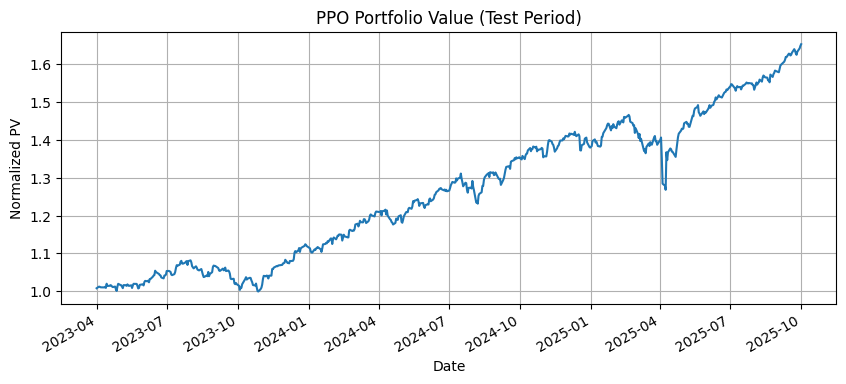

,GLD.US,SPY.US,IEF.US
2023-03-31,23.610001,58.110001,18.280001
2023-04-03,17.150000,69.739998,13.110000
2023-04-04,15.820000,72.440002,11.740000
2023-04-05,19.030001,66.580002,14.390000
2023-04-06,29.299999,46.759998,23.940001
...,...,...,...
2025-09-25,19.260000,66.050003,14.680000
2025-09-26,15.840000,72.279999,11.880000
2025-09-29,19.629999,65.279999,15.090000
2025-09-30,15.600000,72.750000,11.650000


In [21]:
def run_policy(env_vec, model, print_every=50):
    """
    Runs a trained PPO model on the test environment.
    Records portfolio values and allocation weights over time.
    """
    # Unwrap DummyVecEnv
    env = env_vec.envs[0]
    obs, _ = env.reset()

    pvals = [1.0]
    weights = []
    dates = []

    while True:
        # Get model action
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

        # Record portfolio value and weights for *current* valid step
        pvals.append(env.portfolio_value)
        weights.append(info["weights"])

        # Use safe indexing for dates (clamp if at end)
        t_index = min(env.t - 1, len(env.dates) - 1)
        dates.append(env.dates[t_index])

        # Print allocations every N steps
        if (len(pvals) - 1) % print_every == 0:
            w = info["weights"]
            pct_str = ", ".join([f"{a}: {100*w[i]:.1f}%" for i, a in enumerate(env.assets)])
            print(f"{env.dates[t_index].date()}  |  {pct_str}")

        if terminated or truncated:
            break

    pv_series = pd.Series(pvals[1:], index=dates)
    w_df = pd.DataFrame(weights, index=dates, columns=env.assets)
    return pv_series, w_df


# --- Run policy ---
pv_series, w_df = run_policy(test_env, model)

pv_series.index = logret_test.index[LOOKBACK : LOOKBACK + len(pv_series)]

# --- Plot portfolio value ---
ax = pv_series.plot(figsize=(10, 4))
ax.set_title("PPO Portfolio Value (Test Period)")
ax.set_ylabel("Normalized PV")
ax.grid(True)
plt.show()

# --- Show latest allocations ---
display((w_df * 100).round(2))


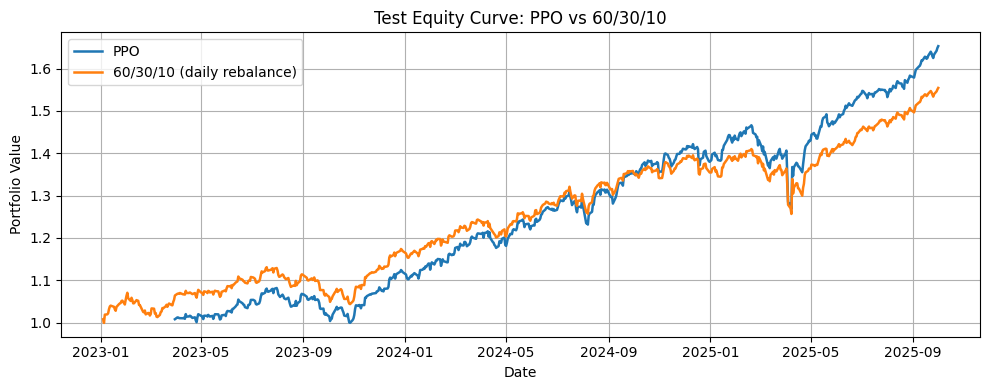

PPO           Sharpe: 1.795
PPO           MDD   : -13.504%
60/30/10     Sharpe: 1.638
60/30/10     MDD   : -10.874%


In [20]:

# --- Align PPO curve to test dates (use the same index as returns) ---
pv_series.index = logret_test.index[LOOKBACK : LOOKBACK + len(pv_series)]

# --- Build a fixed 60/30/10 baseline, mapped by column name ---
# Name your desired weights by *asset symbol*, then map to logret_test columns order
target = {"SPY.US": 0.6, "IEF.US": 0.3, "GLD.US": 0.1}   # edit names to match your columns exactly

# Make weight vector in the *exact* order of logret_test.columns
w_vec = np.array([target.get(col, 0.0) for col in logret_test.columns], dtype=float)
w_vec = w_vec / (w_vec.sum() + 1e-12)  # normalize just in case

# --- Daily-rebalanced baseline (fixed weights each day) ---
gross_ts = np.exp(logret_test.values)  # (T, N) gross = 1 + r
pv = [1.0]
for t in range(gross_ts.shape[0]):
    daily_gross = float(np.dot(w_vec, gross_ts[t]))   # rebalance to w_vec each day
    pv.append(pv[-1] * daily_gross)

baseline_series = pd.Series(pv[1:], index=logret_test.index)

# --- Plot ---
plt.figure(figsize=(10,4))
plt.plot(pv_series, label="PPO", linewidth=1.8)
plt.plot(baseline_series, label="60/30/10 (daily rebalance)", linewidth=1.8)
plt.title("Test Equity Curve: PPO vs 60/30/10")
plt.xlabel("Date"); plt.ylabel("Portfolio Value")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# --- Metrics ---
def sharpe(series, rf=0.0, periods_per_year=252):
    ret = series.pct_change().dropna()
    mu = ret.mean() * periods_per_year
    sd = ret.std() * math.sqrt(periods_per_year)
    return float((mu - rf) / (sd + 1e-12))

def max_drawdown(series):
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    return float(dd.min())

print(f"PPO           Sharpe: {sharpe(pv_series):.3f}")
print(f"PPO           MDD   : {max_drawdown(pv_series):.3%}")
print(f"60/30/10     Sharpe: {sharpe(baseline_series):.3f}")
print(f"60/30/10     MDD   : {max_drawdown(baseline_series):.3%}")

